In [68]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from single_photons.estimators.kalman import KalmanFilter
import seaborn as sns
import pandas as pd

In [407]:
omega = 2*np.pi*1e5
T = 2*np.pi/omega
t = np.arange(0, 15*T, T/1000)
N = t.shape[0]
delta_t = np.diff(t)[0]
m = 1e-17
k = omega*omega*m
hbar=1.05457e-34

In [675]:
gamma = 0.0001
coupling = 0.0001
eta_detec=0.9

In [676]:
variance_process = 2*gamma + 4*np.pi*coupling
std_detection = 4

In [677]:
A = np.array([[0, omega],[-omega, -gamma]])
B = np.array([[0],[1]])
C = np.array([[1, 0]])
Q = np.array([[0, 0], [0, variance_process]])
R = np.array([[np.power(std_detection,2)]])

In [678]:
np.matrix(np.eye(2))

matrix([[1., 0.],
        [0., 1.]])

In [679]:
Ad = np.eye(2)+A*delta_t+0.5*np.matmul(A*delta_t,A*delta_t)
Ad

array([[ 0.99998026,  0.00628319],
       [-0.00628319,  0.99998026]])

In [680]:
P0 = np.matrix(np.eye(2))
estimation = np.matrix([[0],[0]])
states = np.array([[10],[0.]])
u = 0
G = np.array([[0],[1]])
K = np.array([[1, 0], [0, 1e5]])
new_states = np.zeros((N,2)) 
kalman = KalmanFilter(estimation, P0, Ad, B*delta_t, C, Q, R)
measured_states = np.zeros((N, 2))
estimated_states = np.zeros((N, 2))
estimated_states[0,:] = estimation.reshape((2))
estimation = estimation.reshape((2,1))
for i in tqdm(range(t.shape[0])):
    u = -np.matmul(K, estimation).sum()
    new_states[i,:] = states[:,0]
    measured_states[i, :] = states[:, 0] + std_detection*np.random.normal()
    kalman.propagateDynamics(np.array([[u]]))
    kalman.computeAposterioriEstimate(measured_states[i,0])
    estimated_states[i,:] = kalman.estimates_aposteriori[i][:,0].reshape((2))
    estimation = estimated_states[i,:].reshape((2,1))    
    backaction_force = np.sqrt(4*np.pi*coupling)*(np.sqrt(eta_detec)*np.random.normal()+np.sqrt(1-eta_detec)*np.random.normal())
    state_dot = np.matmul(A,states) + B*u
    states += state_dot*delta_t + G*(np.sqrt(2*gamma*delta_t)*np.random.normal()+np.sqrt(delta_t)*backaction_force)
    #states += std_np.random.normal()

100%|███████████████████████████████████| 15001/15001 [00:02<00:00, 5001.26it/s]


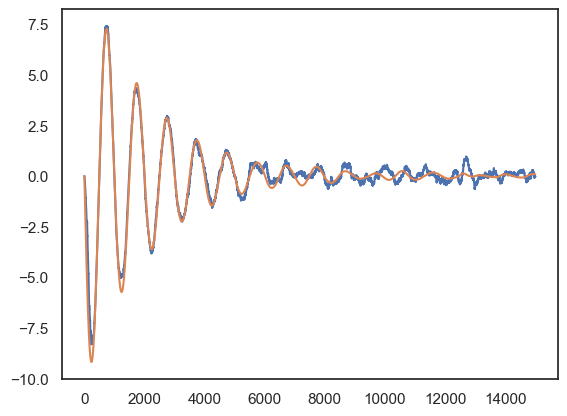

In [681]:
#plt.plot(new_states[:,0])
#plt.plot(measured_states[:,1])
#plt.xlim([0,10000])
plt.plot(estimated_states[:,1])
plt.plot(new_states[:,1])
#plt.ylim([-.2,0])

In [682]:
hbar = 1.054571e-34
m = 1e-17
norm_fac_pos = (1/np.sqrt(omega*m/hbar))
norm_fac_momentum = (1/np.sqrt(1/(omega*hbar*m)))
z = estimated_states[:,0]*norm_fac_pos
p = estimated_states[:,1]*norm_fac_momentum

In [683]:
test_z = np.random.randn((1000))*(1/np.sqrt(omega*m/hbar))
test_p = np.random.randn((1000))*(1/np.sqrt(1/(omega*hbar*m)))
np.sqrt(test_z.var()*test_p.var())/2, hbar/2

(5.03796191616124e-35, 5.272855e-35)

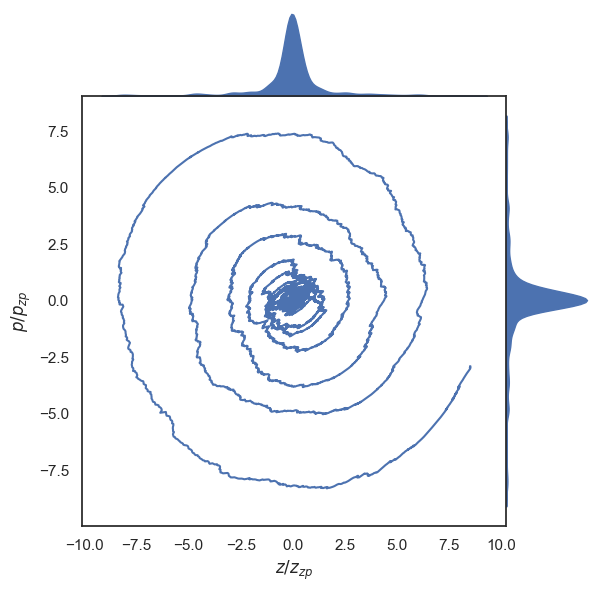

In [685]:
sns.set_theme(style="white")
df = pd.DataFrame()
df['z'] = estimated_states[100:,0]
df['p'] = estimated_states[100:,1]
g = sns.JointGrid(data=df, x="z", y="p", space=0)
g.plot_joint(sns.lineplot, sort = False)#clip=((2200, 6800), (10, 25)),
             #thresh=0, levels=100, cmap="rocket")
g.plot_marginals(sns.kdeplot, alpha=1, fill=True)
g.set_axis_labels(r'$z/z_{zp}$',r'$p/p_{zp}$')

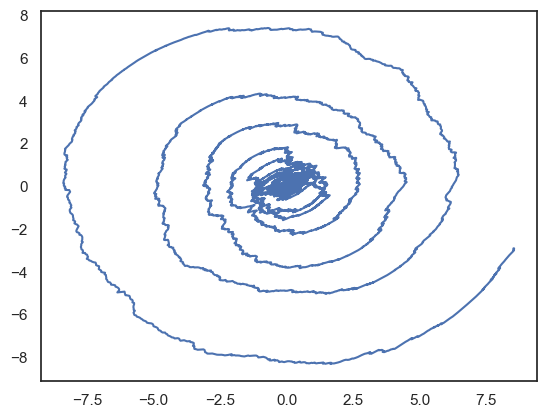

In [686]:
plt.plot(df['z'], df['p'])


In [687]:
cov_mat = kalman.error_covariance_aposteriori[-1]
z_std = norm_fac_pos*np.sqrt(cov_mat[0,0])
p_std = norm_fac_momentum*np.sqrt(cov_mat[1,1])
cov_mat

matrix([[0.12809069, 0.08192917],
        [0.08192917, 0.23435415]])

In [688]:
estimated_states[-30:].var(axis=0)

array([0.00223784, 0.00075823])

In [689]:
(m*np.power(omega, 2)*np.power(z_std,2)+np.power(p_std,2)/m)/(2*hbar*omega)

0.18122242028510172

In [690]:
m*np.power(omega,2)*z_var

4.424342904943671e-09

In [674]:
z_std*p_std, hbar/2

(1.6261725664220648e-35, 5.272855e-35)